In [1]:
import numpy as np
from math import sqrt
import pint
ureg = pint.UnitRegistry()

In [2]:
# http://mathworld.wolfram.com/SpherePointPicking.html
# http://math.stackexchange.com/a/838336

import abc

class BeamSourceBase(metaclass=abc.ABCMeta):
    
    def __init__(self, cutoff_theta_x, cutoff_theta_y):
        self.cutoff_theta_x = cutoff_theta_x
        self.cutoff_theta_y = cutoff_theta_y
        self.n_attempt = 0
        self.n_success = 0
        
    @property
    def cutoff_theta_x(self):
        return self._cutoff_theta_x
    
    @cutoff_theta_x.setter
    def cutoff_theta_x(self, cutoff_theta_x):
        assert(cutoff_theta_x <= np.pi * ureg.radian)
        self._cutoff_theta_x = cutoff_theta_x
        self._cutoff_x1 = self._angle_to_marsaglia_coordinate(cutoff_theta_x)
        
    @property
    def cutoff_theta_y(self):
        return self._cutoff_theta_y
    
    @cutoff_theta_y.setter
    def cutoff_theta_y(self, cutoff_theta_y):
        assert(cutoff_theta_y <= np.pi * ureg.radian)
        self._cutoff_theta_y = cutoff_theta_y
        self._cutoff_x2 = self._angle_to_marsaglia_coordinate(cutoff_theta_y)
        
    @staticmethod
    def _angle_to_marsaglia_coordinate(theta):
        y = np.tan(theta)**2
        if theta <= np.pi * ureg.rad / 2.:
            return sqrt(y/(y+1) - 1./sqrt(y+1) + 1./(y+1)) / sqrt(2)
        else:
            return sqrt(y/(y+1) + 1./sqrt(y+1) + 1./(y+1)) / sqrt(2)
        
    @staticmethod
    def _marsaglia_transform(x1, x2):
        x = 2 * x1 * np.sqrt(1 - np.square(x1) - np.square(x2))
        y = 2 * x2 * np.sqrt(1 - np.square(x1) - np.square(x2))
        z = 1 - 2 * (np.square(x1) + np.square(x2))

        return x, y, z

    @abc.abstractmethod
    def _generate_marsaglia(self, size):
        pass

    def generate(self, size):
        self.n_success += size
        
        x1, x2 = self._generate_marsaglia(size)
        return self._marsaglia_transform(x1, x2)

    def efficiency(self):
        return self.n_success / self.n_attempt if self.n_attempt else None
    
    
class UniformBeamSource(BeamSourceBase):
    
    def __init__(self, cutoff_theta_x, cutoff_theta_y):
        super().__init__(cutoff_theta_x, cutoff_theta_y)
        
    def _generate_marsaglia(self, size):
        self.n_attempt += size
        
        x1 = np.random.uniform(-self._cutoff_x1, self._cutoff_x1, size)
        x2 = np.random.uniform(-self._cutoff_x2, self._cutoff_x2, size)
        
        valid = (np.square(x1)/self._cutoff_x1**2) + (np.square(x2)/self._cutoff_x2**2) <= 1.
        size_regenerate = np.size(valid) - np.count_nonzero(valid)
        if size_regenerate > 0:
            x1[~valid], x2[~valid] = self._generate_marsaglia(size_regenerate)
            
        return x1, x2
        
    
class GaussianBeamSource(BeamSourceBase):
    
    def __init__(self, spread_theta_x, spread_theta_y, 
                 cutoff_theta_x=np.pi*ureg.radian, cutoff_theta_y=np.pi*ureg.radian):
        
        super().__init__(cutoff_theta_x, cutoff_theta_y)
        self.spread_theta_x = spread_theta_x
        self.spread_theta_y = spread_theta_y
        
    @property
    def spread_theta_x(self):
        return self._spread_theta_x
    
    @spread_theta_x.setter
    def spread_theta_x(self, spread_theta_x):
        assert(spread_theta_x <= np.pi * ureg.radian)
        self._spread_theta_x = spread_theta_x
        self._spread_x1 = self._angle_to_marsaglia_coordinate(spread_theta_x)
        
    @property
    def spread_theta_y(self):
        return self._spread_theta_y
    
    @spread_theta_y.setter
    def spread_theta_y(self, spread_theta_y):
        assert(spread_theta_y <= np.pi * ureg.radian)
        self._spread_theta_y = spread_theta_y
        self._spread_x2 = self._angle_to_marsaglia_coordinate(spread_theta_y)
    
    def _generate_marsaglia(self, size):
        self.n_attempt += size
        
        x1 = np.random.normal(0, self._spread_x1, size)
        x2 = np.random.normal(0, self._spread_x2, size)
        
        valid = (np.square(x1)/self._cutoff_x1**2) + (np.square(x2)/self._cutoff_x2**2) <= 1.
        size_regenerate = np.size(valid) - np.count_nonzero(valid)
        if size_regenerate > 0:
            x1[~valid], x2[~valid] = self._generate_marsaglia(size_regenerate)
        
        return x1, x2

In [3]:
# http://stackoverflow.com/questions/29188612/arrows-in-matplotlib-using-mplot3d

from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
source = UniformBeamSource(60*ureg.degree, 120*ureg.degree)
x,y,z = source.generate(1000)

print('Efficiency = {:.1%}'.format(source.efficiency()))
print('Predicted efficiency for UniformBeamSource is {:.1%}'.format(np.pi/4))

Efficiency = 80.5%
Predicted efficiency for UniformBeamSource is 78.5%


<IPython.core.display.Javascript object>


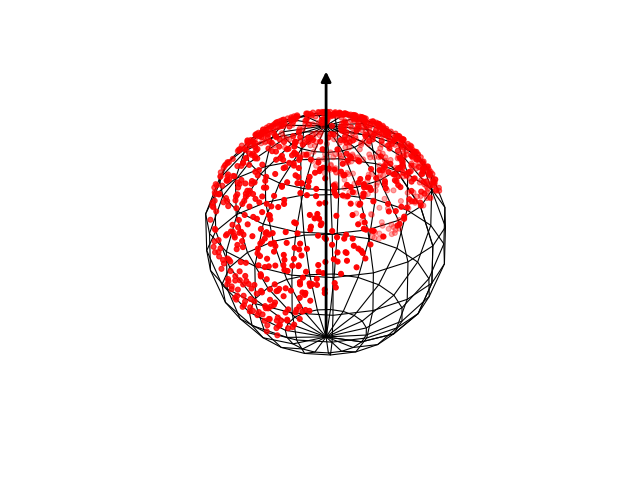

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

# wireframe sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
xx = np.cos(u)*np.sin(v)
yy = np.sin(u)*np.sin(v)
zz = np.cos(v)
ax.plot_wireframe(xx, yy, zz, color='k')

# z-axis arrow
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', linewidth=2.5)
a = Arrow3D([0,0], [0,0], [-1,1.5], **arrow_prop_dict)
ax.add_artist(a)

# data points
ax.scatter(x,y,z, c='r', s=20, edgecolors='face')
plt.show()